In [1]:
%matplotlib inline

In [2]:
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import random
import patsy
import sklearn.linear_model as linear
sns.set(style="whitegrid")

In [3]:
import random as py_random
import matplotlib.pyplot as plt
import pandas as pd
import models
import warnings
warnings.filterwarnings('ignore')

# Problem Set 5 (covers Lab 9 and 10)

## Directions

1. Show all work/steps/calculations using a combination of code and Markdown. You will submit only this notebook named: [jhed_id].ipynb back to Blackboard from whence you downloaded it. Do not return the data to me.
2. **All** work is to be your own. This is not a group project. You may, however, use code from the lectures and labs. Provide citations for any code that is not your own. You may also consult Stackoverflow, etc. This is not by any means "closed book" or anything like that. Basically, I need to see if *you* learned the concepts from the Lectures, *Fundamentals*, and Labs.
3. Add whatever markdown or code cells you need in each part to explain and calculate your answers. Don't just provide answers but explain them as well. **Explain and interpret your results.**

## Introduction

Labs 9 and 10 were all about linear models, specifically linear and logistic regression. We learned how to build and interpret multivariate models by using domain knowledge, comparing the predicted and actual values of the coefficients and the credible intervals, and looking at residuals. We also applied transformations to make the models perform better and increase interpretability.

Using the techniques covered during Modules 9 and 10 (lectures, labs, course notes), **build, describe, and use** a linear regression model that estimates the target variable `mpg` for the accompanying auto data set. You may use other techniques you know but you must at least use the techniques described in class and call out and describe anything "extra" that you do and why.

Do **not** use any feature selection techniques or anything other than linear regression. Follow the method described in class.

The instructions say build, **describe, and use**. You must describe all aspects of your final model (all the parameters and metrics) and use it to predict one value as described in the course notes.

## Table of Contents

* [Context](#context)
* [ETL](#etl)
* [Single Variable EDA](#eda)
* [Correlations](#correlation)
* [Pairwise EDA](#pairwise)
* [Linear Regression Model](#model)
* [Model Evaluation](#evaluation)

<a id="context"></a>
### Context

Before starting the work, it is important to understand the context of the dataset and define a question statement. we would first take a look at the dataset info and meta data from the name file

In [4]:
f = open("auto-mpg.names.txt", "r")
print(f.read())

1. Title: Auto-Mpg Data

2. Sources:
   (a) Origin:  This dataset was taken from the StatLib library which is
                maintained at Carnegie Mellon University. The dataset was 
                used in the 1983 American Statistical Association Exposition.
   (c) Date: July 7, 1993

3. Past Usage:
    -  See 2b (above)
    -  Quinlan,R. (1993). Combining Instance-Based and Model-Based Learning.
       In Proceedings on the Tenth International Conference of Machine 
       Learning, 236-243, University of Massachusetts, Amherst. Morgan
       Kaufmann.

4. Relevant Information:

   This dataset is a slightly modified version of the dataset provided in
   the StatLib library.  In line with the use by Ross Quinlan (1993) in
   predicting the attribute "mpg", 8 of the original instances were removed 
   because they had unknown values for the "mpg" attribute.  The original 
   dataset is available in the file "auto-mpg.data-original".

   "The data concerns city-cycle fuel consumptio

Based on the information, we can see the dataset tries to study mpg (miles per gallon gasoline consumption) based on several features of a car including cylinders, displacement, horsepower, weight, acceleration, model year, origin and car name.

Therefore, this analysis would focus on building on linear regression model to predict mpg based on selected features.

<a id="etl"></a>
### ETL

In [5]:
df = pd.read_table('auto-mpg.data.txt', sep='\s+', header=None, names=['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration','modelyear', 'origin', 'carname'])
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,modelyear,origin,carname
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


Based on the data, carname seems to be a field that is hard to parse or factorize. Therefore, we would exclude it from this analysis

In [6]:
df = df.drop('carname', 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
mpg             398 non-null float64
cylinders       398 non-null int64
displacement    398 non-null float64
horsepower      398 non-null object
weight          398 non-null float64
acceleration    398 non-null float64
modelyear       398 non-null int64
origin          398 non-null int64
dtypes: float64(4), int64(3), object(1)
memory usage: 25.0+ KB


The horsepower data type is expected to be numbers but it is showing as object. Based on dataset info, we know there are some missing values inside that column which we need to remove.

In [7]:
df[~df.horsepower.str.match('^\-?(\d*\.?\d+|\d+\.?\d*)$')]

,mpg,cylinders,displacement,horsepower,weight,acceleration,modelyear,origin
32,25.0,4,98.0,?,2046.0,19.0,71,1
126,21.0,6,200.0,?,2875.0,17.0,74,1
330,40.9,4,85.0,?,1835.0,17.3,80,2
336,23.6,4,140.0,?,2905.0,14.3,80,1
354,34.5,4,100.0,?,2320.0,15.8,81,2
374,23.0,4,151.0,?,3035.0,20.5,82,1


In [8]:
data = df[df.horsepower != '?']
data.horsepower = data.horsepower.astype('float')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 397
Data columns (total 8 columns):
mpg             392 non-null float64
cylinders       392 non-null int64
displacement    392 non-null float64
horsepower      392 non-null float64
weight          392 non-null float64
acceleration    392 non-null float64
modelyear       392 non-null int64
origin          392 non-null int64
dtypes: float64(5), int64(3)
memory usage: 27.6 KB


In [9]:
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,modelyear,origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


Now the dataset is cleaned and we are ready to start our analysis.

<a id="eda"></a>
### Single Variable EDA

Before looking into specific column, let's start with a some quick statistics for each columns 

In [10]:
df.describe()

,mpg,cylinders,displacement,weight,acceleration,modelyear,origin
count,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,5140.000000,24.800000,82.000000,3.000000


Not let's look into the values and distributions of each variable

#### mpg

In [11]:
df.mpg.describe()

count    398.000000
mean      23.514573
std        7.815984
min        9.000000
25%       17.500000
50%       23.000000
75%       29.000000
max       46.600000
Name: mpg, dtype: float64

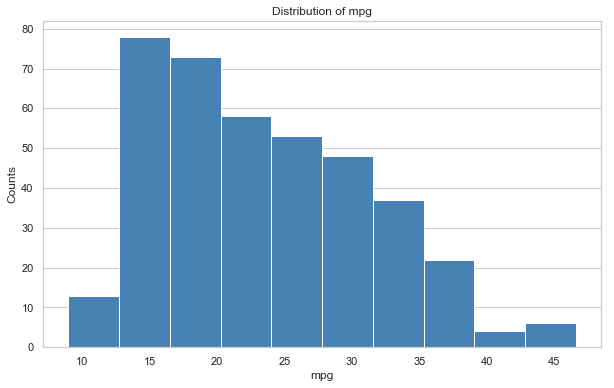

In [12]:
figure = plt.figure(figsize=(10, 6))
axes = figure.add_subplot(1, 1, 1)
axes.hist(data.mpg, color="steelblue")
axes.set_title("Distribution of mpg")
axes.set_xlabel("mpg")
axes.set_ylabel("Counts")
axes.yaxis.grid( b=True, which="major")
axes.xaxis.grid(False)
plt.show()
plt.close()

The distribution of the mpg is right skewed with mean at 23.5.

#### cylinders

In [13]:
df.cylinders.describe()

count    398.000000
mean       5.454774
std        1.701004
min        3.000000
25%        4.000000
50%        4.000000
75%        8.000000
max        8.000000
Name: cylinders, dtype: float64

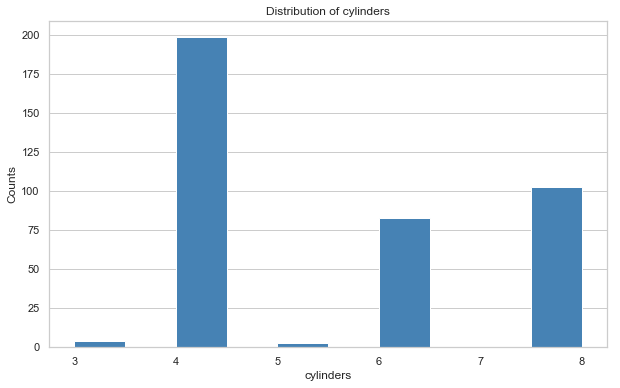

In [14]:
figure = plt.figure(figsize=(10, 6))
axes = figure.add_subplot(1, 1, 1)
axes.hist(data.cylinders, color="steelblue")
axes.set_title("Distribution of cylinders")
axes.set_xlabel("cylinders")
axes.set_ylabel("Counts")
axes.yaxis.grid( b=True, which="major")
axes.xaxis.grid(False)
plt.show()
plt.close()

Most of the cylinders are gathered at 4, 6, and 8 with 4 being the most frequent number

#### displacement

In [15]:
df.displacement.describe()

count    398.000000
mean     193.425879
std      104.269838
min       68.000000
25%      104.250000
50%      148.500000
75%      262.000000
max      455.000000
Name: displacement, dtype: float64

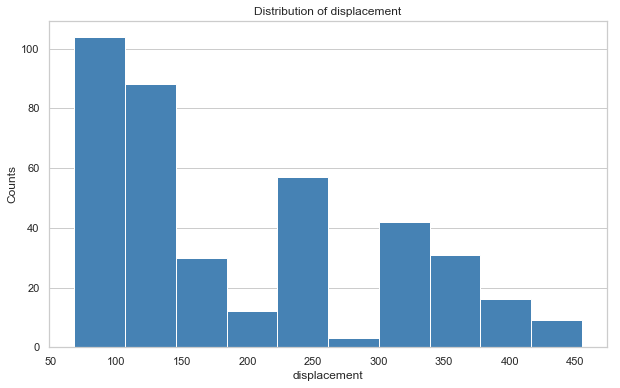

In [16]:
figure = plt.figure(figsize=(10, 6))
axes = figure.add_subplot(1, 1, 1)
axes.hist(data.displacement, color="steelblue")
axes.set_title("Distribution of displacement")
axes.set_xlabel("displacement")
axes.set_ylabel("Counts")
axes.yaxis.grid( b=True, which="major")
axes.xaxis.grid(False)
plt.show()
plt.close()

The distribution of the displacement is right skewed with mean at 193.

#### horsepower

In [17]:
df.horsepower.describe()

count       398
unique       94
top       150.0
freq         22
Name: horsepower, dtype: object

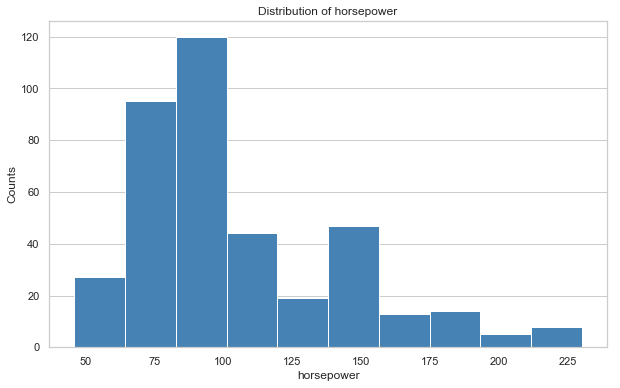

In [18]:
figure = plt.figure(figsize=(10, 6))
axes = figure.add_subplot(1, 1, 1)
axes.hist(data.horsepower, color="steelblue")
axes.set_title("Distribution of horsepower")
axes.set_xlabel("horsepower")
axes.set_ylabel("Counts")
axes.yaxis.grid( b=True, which="major")
axes.xaxis.grid(False)
plt.show()
plt.close()

The distribution of the horsepower is right skewed with mean at 193.

#### weight

In [22]:
df.weight.describe()

count     398.000000
mean     2970.424623
std       846.841774
min      1613.000000
25%      2223.750000
50%      2803.500000
75%      3608.000000
max      5140.000000
Name: weight, dtype: float64

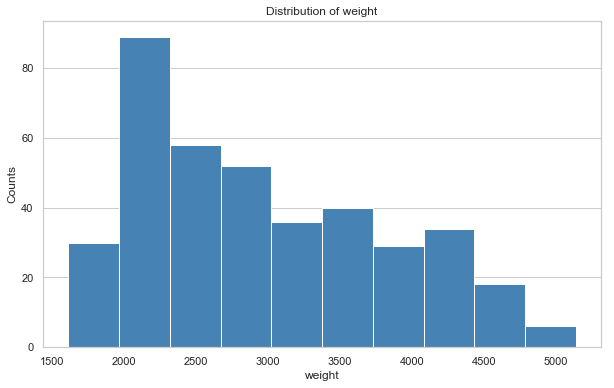

In [23]:
figure = plt.figure(figsize=(10, 6))
axes = figure.add_subplot(1, 1, 1)
axes.hist(data.weight, color="steelblue")
axes.set_title("Distribution of weight")
axes.set_xlabel("weight")
axes.set_ylabel("Counts")
axes.yaxis.grid( b=True, which="major")
axes.xaxis.grid(False)
plt.show()
plt.close()

The distribution of the weight is right skewed with mean at 2970.

#### acceleration

In [24]:
df.acceleration.describe()

count    398.000000
mean      15.568090
std        2.757689
min        8.000000
25%       13.825000
50%       15.500000
75%       17.175000
max       24.800000
Name: acceleration, dtype: float64

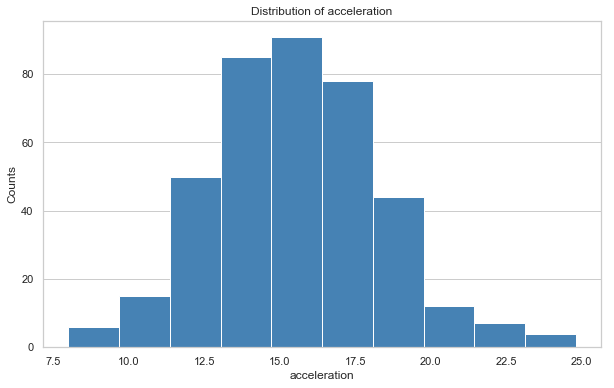

In [25]:
figure = plt.figure(figsize=(10, 6))
axes = figure.add_subplot(1, 1, 1)
axes.hist(data.acceleration, color="steelblue")
axes.set_title("Distribution of acceleration")
axes.set_xlabel("acceleration")
axes.set_ylabel("Counts")
axes.yaxis.grid( b=True, which="major")
axes.xaxis.grid(False)
plt.show()
plt.close()

The acceleration has a normal distribution with mean at 15.56

#### modelyear

In [26]:
df.modelyear.describe()

count    398.000000
mean      76.010050
std        3.697627
min       70.000000
25%       73.000000
50%       76.000000
75%       79.000000
max       82.000000
Name: modelyear, dtype: float64

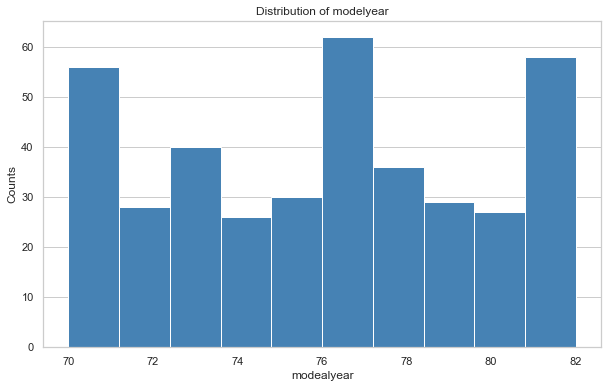

In [27]:
figure = plt.figure(figsize=(10, 6))
axes = figure.add_subplot(1, 1, 1)
axes.hist(data.modelyear, color="steelblue")
axes.set_title("Distribution of modelyear")
axes.set_xlabel("modealyear")
axes.set_ylabel("Counts")
axes.yaxis.grid( b=True, which="major")
axes.xaxis.grid(False)
plt.show()
plt.close()

Model year seems to be evely distributed with 70, 76, 82 has higher counts compared to the rest

#### origin

In [28]:
df.origin.describe()

count    398.000000
mean       1.572864
std        0.802055
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        3.000000
Name: origin, dtype: float64

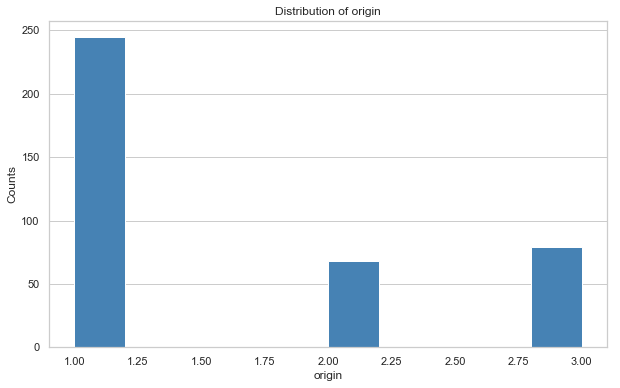

In [29]:
figure = plt.figure(figsize=(10, 6))
axes = figure.add_subplot(1, 1, 1)
axes.hist(data.origin, color="steelblue")
axes.set_title("Distribution of origin")
axes.set_xlabel("origin")
axes.set_ylabel("Counts")
axes.yaxis.grid( b=True, which="major")
axes.xaxis.grid(False)
plt.show()
plt.close()

origin is either 1, 2, or 3 with 1 being the most requent category

<a id="pairwise"></a>
### Pairwise EDA

### mpg v. cylinders

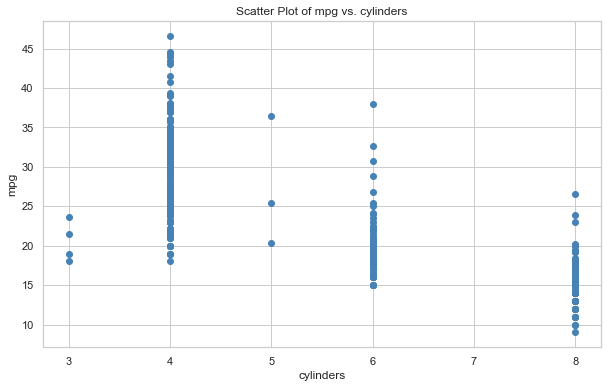

In [30]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(data.cylinders, data.mpg, marker="o", color="steelblue")

axes.set_ylabel("mpg")
axes.set_xlabel("cylinders")
axes.set_title("Scatter Plot of mpg vs. cylinders")

plt.show()
plt.close()

In [31]:
grouped = data.groupby( "cylinders")
grouped_y = grouped["mpg"].describe()
print(grouped_y)

           count       mean       std   min    25%    50%    75%   max
cylinders                                                             
3            4.0  20.550000  2.564501  18.0  18.75  20.25  22.05  23.7
4          199.0  29.283920  5.670546  18.0  25.00  28.40  32.95  46.6
5            3.0  27.366667  8.228204  20.3  22.85  25.40  30.90  36.4
6           83.0  19.973494  3.828809  15.0  18.00  19.00  21.00  38.0
8          103.0  14.963107  2.836284   9.0  13.00  14.00  16.00  26.6


The relationship isn't clear but there seems to be negative relationship between mpg and cylinders which means higher the cylinder, less the mpg.

### mpg v. displacement

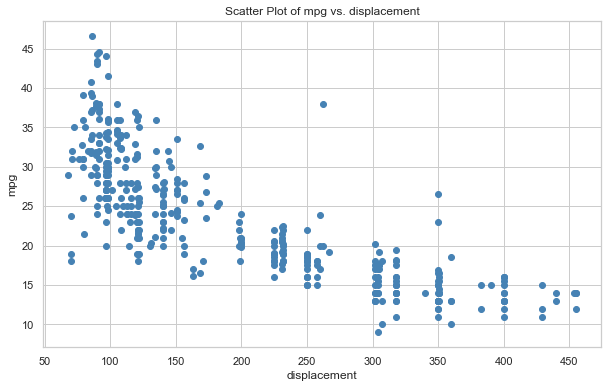

In [32]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(data.displacement, data.mpg, marker="o", color="steelblue")

axes.set_ylabel("mpg")
axes.set_xlabel("displacement")
axes.set_title("Scatter Plot of mpg vs. displacement")

plt.show()
plt.close()

There is a negative relationship between mpg and displacement which means higher the displacement, lower the mpg

### mpg v. horsepower

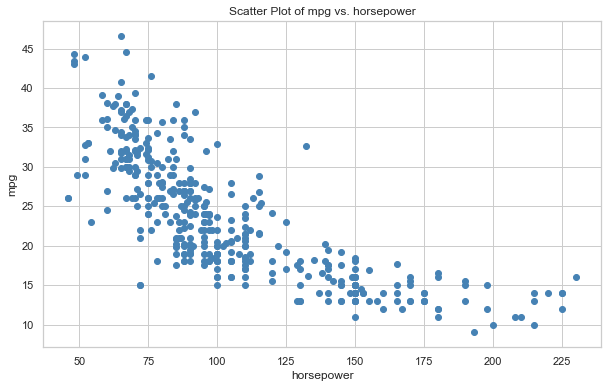

In [33]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(data.horsepower, data.mpg, marker="o", color="steelblue")

axes.set_ylabel("mpg")
axes.set_xlabel("horsepower")
axes.set_title("Scatter Plot of mpg vs. horsepower")

plt.show()
plt.close()

There is a negative relationship between mpg and horsepower which means higher the horsepower, lower the mpg

### mpg v. weight

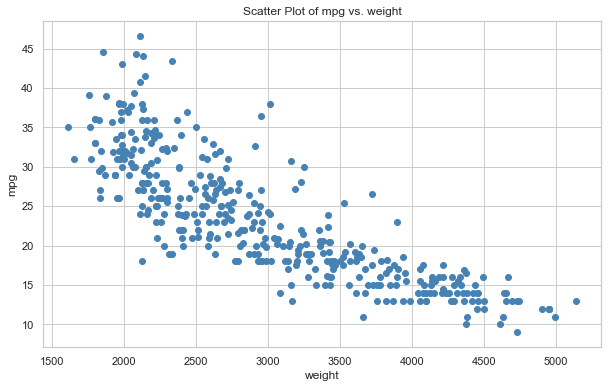

In [34]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(data.weight, data.mpg, marker="o", color="steelblue")

axes.set_ylabel("mpg")
axes.set_xlabel("weight")
axes.set_title("Scatter Plot of mpg vs. weight")

plt.show()
plt.close()

There is a negative relationship between mpg and weight which means higher the weight, higher the mpg

### mpg v. acceleration

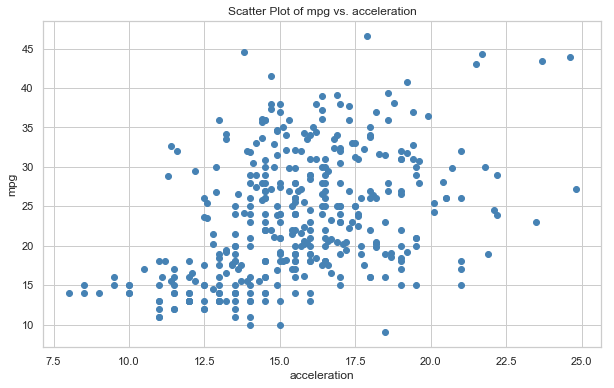

In [35]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(data.acceleration, data.mpg, marker="o", color="steelblue")

axes.set_ylabel("mpg")
axes.set_xlabel("acceleration")
axes.set_title("Scatter Plot of mpg vs. acceleration")

plt.show()
plt.close()

There is no clear relationship between acceleration and mpg

### mpg v. modelyear

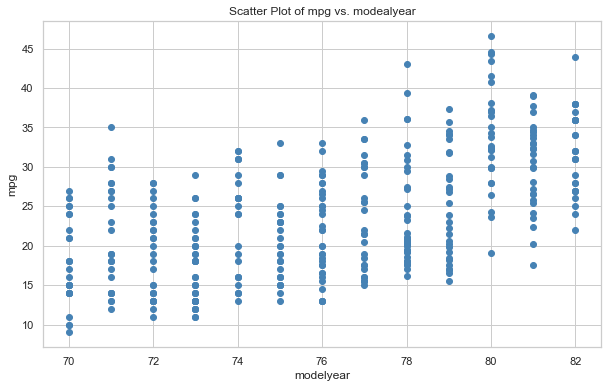

In [36]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(data.modelyear, data.mpg, marker="o", color="steelblue")

axes.set_ylabel("mpg")
axes.set_xlabel("modelyear")
axes.set_title("Scatter Plot of mpg vs. modealyear")

plt.show()
plt.close()

There is a positive relationship between mpg and model year which means newer the model year, higher the mpg

### mpg v. origin

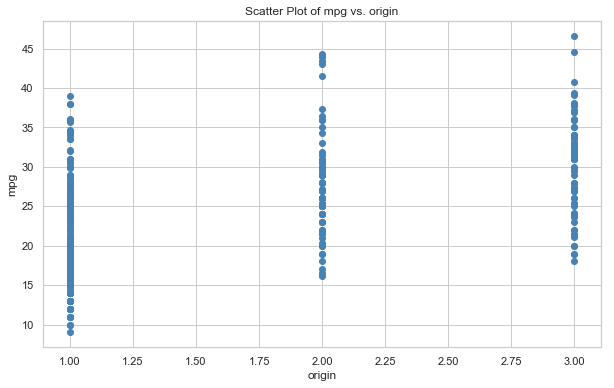

In [37]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(data.origin, data.mpg, marker="o", color="steelblue")

axes.set_ylabel("mpg")
axes.set_xlabel("origin")
axes.set_title("Scatter Plot of mpg vs. origin")

plt.show()
plt.close()

There is a positive relationship between mpg and origin which means higher the origin, higher the mpg

<a id="correlation"></a>
### Correlation

Let's also quickly look at the correlations to understand the relationship among features.

                   mpg  cylinders  displacement  horsepower    weight  \
mpg           1.000000  -0.777618     -0.805127   -0.778427 -0.832244   
cylinders    -0.777618   1.000000      0.950823    0.842983  0.897527   
displacement -0.805127   0.950823      1.000000    0.897257  0.932994   
horsepower   -0.778427   0.842983      0.897257    1.000000  0.864538   
weight       -0.832244   0.897527      0.932994    0.864538  1.000000   
acceleration  0.423329  -0.504683     -0.543800   -0.689196 -0.416839   
modelyear     0.580541  -0.345647     -0.369855   -0.416361 -0.309120   
origin        0.565209  -0.568932     -0.614535   -0.455171 -0.585005   

              acceleration  modelyear    origin  
mpg               0.423329   0.580541  0.565209  
cylinders        -0.504683  -0.345647 -0.568932  
displacement     -0.543800  -0.369855 -0.614535  
horsepower       -0.689196  -0.416361 -0.455171  
weight           -0.416839  -0.309120 -0.585005  
acceleration      1.000000   0.290316  0.2

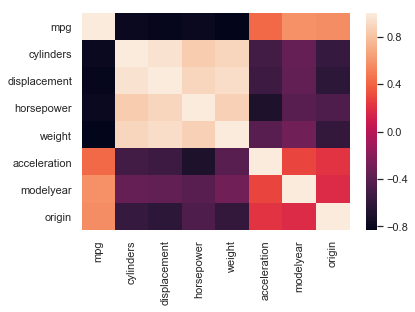

In [38]:
#correlations
corr = data.corr()
print(corr)
sns.heatmap(corr, xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

Based on the graph above, we see cylinders, displacement, horsepower, weight seem to have strong negative impact on mpg whereas model year and origin has positive impact on mpg. Also, we see cylinders, displacement, horsepower, and weight are correlated to each other

In [39]:
def correlations(data, y, xs):
    rs = []
    rhos = []
    for x in xs:
        r = stats.pearsonr(data[y], data[x])[0]
        rs.append(r)
        rho = stats.spearmanr(data[y], data[x])[0]
        rhos.append(rho)
    return pd.DataFrame({"feature": xs, "r": rs, "rho": rhos})

In [40]:
correlations(data, 'mpg', ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration','modelyear', 'origin'])

,feature,r,rho
0,cylinders,-0.777618,-0.823175
1,displacement,-0.805127,-0.855234
2,horsepower,-0.778427,-0.853616
3,weight,-0.832244,-0.875585
4,acceleration,0.423329,0.441539
5,modelyear,0.580541,0.574841
6,origin,0.565209,0.580482


Referring to chart above, we see the most of the relationships show the same relationship as pairwise analysis and Spearman's  suggests all relationship tends to be linear

Based on our pairwise EDA with the target variable, we predict our features' impact to mpg would be below:

* cylinder - negative
* horsepower - negative
* displacement - negative
* weight - negative
* acceleration - positve
* modelyear - positive
* origin - positive

<a id="model"></a>
### Linear Model

before we start, let's look at the null model

In [41]:
data.mpg.describe()

count    392.000000
mean      23.445918
std        7.805007
min        9.000000
25%       17.000000
50%       22.750000
75%       29.000000
max       46.600000
Name: mpg, dtype: float64

The lowest mpg is 9 and the highest is 46.6. The mean is 23 with a standard deviation of 7.8. We can think of 7.8 as the sigma of the Null model.

Now we can build the first linear model with our "all in" model

In [42]:
model1 = "mpg ~ cylinders + displacement + horsepower + weight + acceleration +  modelyear + origin"
result1 = models.bootstrap_linear_regression(model1, data)
models.describe_bootstrap_lr(result1)

The correlation coefficient R^2 is 82% which is fairly good. The error has been cut from Null model's 7.8 to model1's 3.33. But we have already seen that mpg is not Normally distributed so the overall error might not be good to use. For coefficients:

* The intercept isn't particularly interesting here because we cannot have features equal to zero for a car
* cylinders is negative as expected and mixed supported by the data.
* displacement is positive which is not as expected, and mixed supported by the data.
* horsepower is negative as expected and mixed supported by the data.
* weight is negative as expected and strong supported by the data.
* acceleration is positive which is not expected and mixed supported by the data.
* model year is positive and strongly supported by the data.
* origin is positive and strongly supported by the data.

With our first model done, here's what we think we know:

1. displacement results are not expected and not meaningful so we might want to exclude it from the model
2. mpg is not normally distributed so a transformation is probably in order.


Let's see if removing acceleration would impact our model

In [44]:
model2 = "mpg ~ cylinders + horsepower + weight + acceleration + modelyear + origin"
result2 = models.bootstrap_linear_regression(model2, data)
models.describe_bootstrap_lr(result2)

R^2 is the same which means removing displacement and acceleration has no impact on our model's accuracy. Let's also validated through adjusted R^2

In [45]:
print("Before removing displacement: {0}".format(models.adjusted_r_squared(result1)))
print("After removing displacement: {0}".format(models.adjusted_r_squared(result2)))

Before removing displacement: 0.8172720625761632
After removing displacement: 0.8144226616183934


As a result, we would remove displacement from our model

Let's look at the residuals:

In [46]:
def plot_residuals(result, variables):
    figure = plt.figure(figsize=(20,15))

    #variables = ["age", "bmi", "children"]

    plots = len( variables)
    rows = (plots // 3) + 1

    residuals = np.array([r[0] for r in result["residuals"]])
    limits = max(np.abs(residuals.min()), residuals.max())
    
    n = result["n"]
    for i, variable in enumerate( variables):
        axes = figure.add_subplot(rows, 3, i + 1)

        keyed_values = sorted(zip(data[variable].values, residuals), key=lambda x: x[ 0])
        ordered_residuals = [x[ 1] for x in keyed_values]

        axes.plot(list(range(0, n)), ordered_residuals, '.', color="dimgray", alpha=0.75)
        axes.axhline(y=0.0, xmin=0, xmax=n, c="firebrick", alpha=0.5)
        axes.set_ylim((-limits, limits))
        axes.set_ylabel("residuals")
        axes.set_xlabel(variable)

    plt.show()
    plt.close()
    
    return residuals

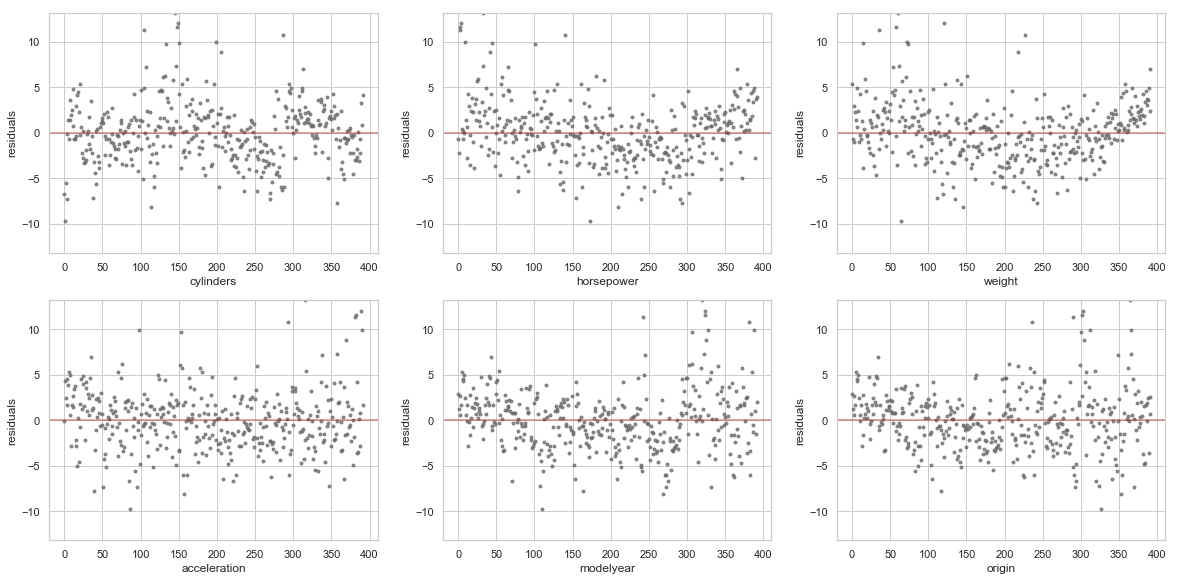

In [47]:
residuals2 = plot_residuals(result2, ['cylinders', 'horsepower','weight', 'acceleration','modelyear', 'origin'])

Most of the graphs are fine but we see patterns in weight and horsepower's residual plot. They might need transformation later.

We mentioned before that mpg is not normally distributed so we would like to resolve that by transform mpg through log

In [48]:
data["log_mpg"] = data["mpg"].apply(np.log)

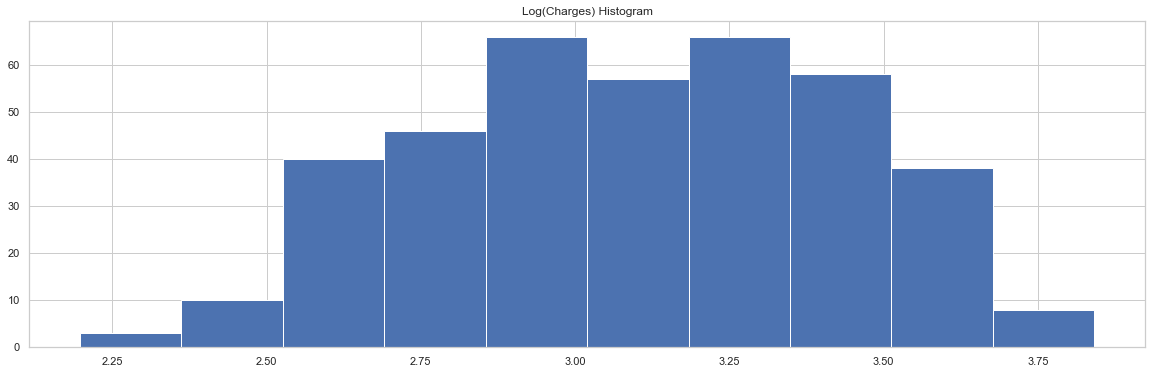

In [49]:
figure = plt.figure(figsize=(20,6))
axes = figure.add_subplot(1,1,1)
axes.hist(data.log_mpg)
axes.set_title("Log(Charges) Histogram")
plt.show()
plt.close()

The distribution is close to normal and symmetric now. We can try this as response variable.

In [50]:
model3 = "log_mpg ~ cylinders + horsepower + weight + acceleration +  modelyear + origin"
result3 = models.bootstrap_linear_regression(model3, data)
models.describe_bootstrap_lr(result3)

The R^2 is better but adding log to mpg causes coefficient of cylinder, horsepower, weight, and acceleration become too small, we might want to apply log to them as well

In [51]:
data["log_cylinders"] = data["cylinders"].apply(np.log)
data["log_acceleration"] = data["acceleration"].apply(np.log)
data["log_horsepower"] = data["horsepower"].apply(np.log)
data["log_weight"] = data["weight"].apply(np.log)

In [53]:
model4 = "log_mpg ~ log_cylinders + log_horsepower + log_weight + log_acceleration + modelyear + origin"
result4 = models.bootstrap_linear_regression(model4, data)
models.describe_bootstrap_lr(result4)

This gives us a better R^2 0.89 with sigma cut to 0.11

Let's look at residuals

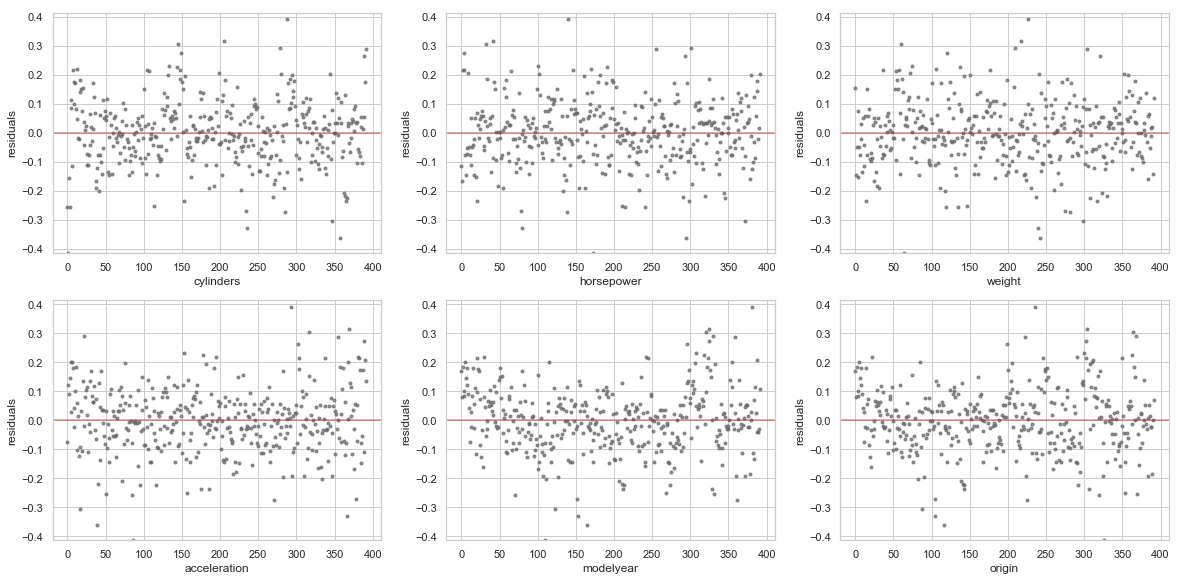

In [54]:
residuals4 = plot_residuals(result4, ['cylinders', 'horsepower','weight', 'acceleration','modelyear', 'origin'])

Our errors are much more symmetric now

Now let's evaluate if adding interaction team can further improve our model

Let's start with a couple of more significant features

In [55]:
model6 = "log_mpg ~ log_cylinders + log_horsepower + log_weight + log_acceleration + modelyear + origin + modelyear:origin"
result6 = models.bootstrap_linear_regression(model6, data)
models.describe_bootstrap_lr(result6)

In [56]:
model7 = "log_mpg ~ log_cylinders + log_horsepower + log_weight + log_acceleration + modelyear + origin + log_horsepower:log_weight "
result7 = models.bootstrap_linear_regression(model7, data)
models.describe_bootstrap_lr(result7)

In [57]:
model7 = "log_mpg ~ log_cylinders + log_horsepower + log_weight + log_acceleration + modelyear + origin + log_cylinders:log_horsepower "
result7 = models.bootstrap_linear_regression(model7, data)
models.describe_bootstrap_lr(result7)

In [58]:
model8 = "log_mpg ~ log_cylinders + log_horsepower + log_weight + log_acceleration + modelyear + origin + log_acceleration:log_horsepower "
result8 = models.bootstrap_linear_regression(model8, data)
models.describe_bootstrap_lr(result8)

Adding interation term doesn't seem to improve our model. Therefore, we will finalize our model as below

In [59]:
modelfinal = "log_mpg ~ log_cylinders + log_horsepower + log_weight + log_acceleration + modelyear + origin"
resultfinal = models.bootstrap_linear_regression(modelfinal, data)
models.describe_bootstrap_lr(resultfinal)

<a id="evaluation"></a>
### Model Evaluation

In [60]:
from collections import defaultdict

In [61]:
def chunk(xs, n):
    k, m = divmod(len(xs), n)
    return [xs[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n)]

def data_collection():
    result = dict()
    result[ "train"] = defaultdict( list)
    result[ "test"] = defaultdict( list)
    return result

def learning_curves(algorithm, formula, data, evaluate, fold_count=10, repetitions=3, increment=1):
    indices = list(range(len( data)))
    results = data_collection()
    for _ in range(repetitions):
        random.shuffle(indices)
        folds = chunk(indices, fold_count)
        for fold in folds:
            test_data = data.iloc[ fold]
            train_indices = [idx for idx in indices if idx not in fold]
            train_data = data.iloc[train_indices]
            for i in list(range(increment, 100, increment)) + [100]: # ensures 100% is always picked.
                # the indices are already shuffled so we only need to take ever increasing chunks
                train_chunk_size = int( np.ceil((i/100)*len( train_indices)))
                train_data_chunk = data.iloc[train_indices[0:train_chunk_size]]
                # we calculate the model
                result = algorithm(formula, data=train_data_chunk)
                model = result["model"]
                # we calculate the results for the training data subset
                y, X = patsy.dmatrices( formula, train_data_chunk, return_type="matrix")
                result = models.summarize(formula, X, y, model)
                metric = evaluate(result)
                results["train"][i].append( metric)
                
                # we calculate the results for the test data.
                y, X = patsy.dmatrices( formula, test_data, return_type="matrix")
                result = models.summarize(formula, X, y, model)
                metric = evaluate(result)
                results["test"][i].append( metric)
            #
        #
    # process results
    # Rely on the CLT...
    statistics = {}
    for k, v in results["train"].items():
        statistics[ k] = (np.mean(v), np.std(v))
    results["train"] = statistics
    statistics = {}
    for k, v in results["test"].items():
        statistics[ k] = (np.mean(v), np.std(v))
    results["test"] = statistics
    return results

def cross_validation(algorithm, formula, data, evaluate, fold_count=10, repetitions=3):
    indices = list(range(len( data)))
    metrics = []
    for _ in range(repetitions):
        random.shuffle(indices)
        folds = chunk(indices, fold_count)
        for fold in folds:
            test_data = data.iloc[fold]
            train_indices = [idx not in fold for idx in indices]
            train_data = data.iloc[train_indices]
            result = algorithm(formula, data=train_data)
            model = result["model"]
            y, X = patsy.dmatrices(formula, test_data, return_type="matrix")
            # y = np.ravel( y) # might need for logistic regression
            results = models.summarize(formula, X, y, model)
            metric = evaluate(results)
            metrics.append(metric)
    return metrics
#

def results_to_curves( curve, results):
    all_statistics = results[ curve]
    keys = list( all_statistics.keys())
    keys.sort()
    mean = []
    upper = []
    lower = []
    for k in keys:
        m, s = all_statistics[ k]
        mean.append( m)
        upper.append( m + 2 * s)
        lower.append( m - 2 * s)
    return keys, lower, mean, upper

def plot_learning_curves( results, metric, zoom=False):
    figure = plt.figure(figsize=(10,6))

    axes = figure.add_subplot(1, 1, 1)

    xs, train_lower, train_mean, train_upper = results_to_curves( "train", results)
    _, test_lower, test_mean, test_upper = results_to_curves( "test", results)

    axes.plot( xs, train_mean, color="steelblue")
    axes.fill_between( xs, train_upper, train_lower, color="steelblue", alpha=0.25, label="train")
    axes.plot( xs, test_mean, color="firebrick")
    axes.fill_between( xs, test_upper, test_lower, color="firebrick", alpha=0.25, label="test")
    axes.legend()
    axes.set_xlabel( "training set (%)")
    axes.set_ylabel( metric)
    axes.set_title("Learning Curves")

    if zoom:
        y_lower = int( 0.9 * np.amin([train_lower[-1], test_lower[-1]]))
        y_upper = int( 1.1 * np.amax([train_upper[-1], test_upper[-1]]))
        axes.set_ylim((y_lower, y_upper))

    plt.show()
    plt.close()
#

Here we will perform three rounds of 10-fold cross validation and calculate 95% Bootstrap estimates of the credible intervals for R^2 and sigma

In [62]:
formula = modelfinal

In [63]:
validationresult = cross_validation(models.linear_regression, formula, data, lambda r: (r["sigma"], r["r_squared"]))

In [65]:
sigmas = [r[0] for r in validationresult]
r_squareds = [r[1] for r in validationresult]

In [66]:
print("mean sigma: ", np.mean(sigmas))
print("mean R^2: ", np.mean(r_squareds))

mean sigma:  0.12323242140680071
mean R^2:  0.8876073177917913


In [67]:
def resample(data):
    n = len(data)
    return [data[ i] for i in [stats.randint.rvs(0, n - 1) for _ in range( 0, n)]]

In [68]:
bootstrap = {}
bootstrap["sigma"] = np.array([np.mean(s) for s in [resample(sigmas) for i in range( 0, 1000)]])
bootstrap["r_squared"] = np.array([np.mean(r) for r in [resample(r_squareds) for i in range( 0, 1000)]])

In [69]:
print(r"95% CI for *mean* sigma:", stats.mstats.mquantiles(bootstrap["sigma"], [0.025, 0.975]))

95% CI for *mean* sigma: [0.11850842 0.1289986 ]


In [70]:
print(r"95% CI for *mean* R^2:", stats.mstats.mquantiles(bootstrap["r_squared"], [0.025, 0.975]))

95% CI for *mean* R^2: [0.87586596 0.89575457]


We have fairly tight bounds on what we think the average sigma and R^2 are for our model.

Also, we would like to see the current state of the model and if more data would help improve the model

In [71]:

result = learning_curves(models.linear_regression, formula, data, lambda r: r["sigma"])

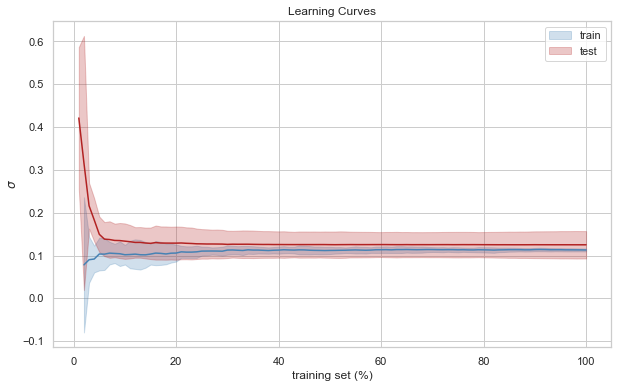

In [72]:
plot_learning_curves(result, r"$\sigma$")

Based on the graph above, we can see our model is fairly good and at a low bias low variance state so adding more data is not likely to improve the model.